<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/Diffusion_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1D Diffusion**

This notebook validates the Fokker-Planck like equation derived in the paper Craske J. et al. 2024 by computing each of the relevant terms numerically for the case of 1D scalar diffusion on a bounded domain. To solve this equation we use the open source pseudo-spectral code Dedalus.

**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [ ]:
# # Set environment variables for best performance
# %env OMP_NUM_THREADS=1
# %env NUMEXPR_MAX_THREADS=1

# # Minimize logging output
# import logging
# logging.disable(logging.DEBUG)

# # Check if running on google colab
# import os
# using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# # Check for Dedalus
# try:
#     import dedalus.public as de
#     print("Dedalus already installed :)")
# except:
#     print("Dedalus not installed yet.")
#     if using_google_colab:
#         print("Installing for Google Colab.")
#         print()
#         # Step 1: Install FFTW
#         !apt-get install libfftw3-dev
#         !apt-get install libfftw3-mpi-dev
#         # Step 2: Set paths for Dedalus installation
#         import os
#         os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
#         os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
#         os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
#         os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
#         # Step 3: Install Dedalus using pip
#         !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
#         !pip3 install -q ipympl
#         # Step 4: Check installation
#         print()
#         try:
#             import dedalus.public as de
#             print("Dedalus successfully installed :)")
#         except:
#             print("Error installing Dedalus :(")
#             raise
#     else:
#         print("See website for installation instructions:")
#         print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# # Setup interactive matplotlib
# if using_google_colab:
#     from google.colab import output
#     output.enable_custom_widget_manager()


**Content**

First let's import everything we need to run the rest of the notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)
#%matplotlib widget


Next we solve the equation for the scalar concentration
\begin{equation}
\partial_t C = \kappa \partial_z^2 C, \quad z \in [0,1],
\end{equation}
over the time interval $t \in [0,1]$ subject to the Robin boundary conditions
\begin{aligned}
 \Gamma C - \beta \partial_z C &= g_0(t), \quad \text{at} \quad z = 0, \\
 \Gamma C + \beta \partial_z C &= g_1(t), \quad \text{at} \quad z = 1,
\end{aligned}
for the initial condition
\begin{equation}
C(z,t=0) = \tanh(10(z-1/2)).
\end{equation}

In [ ]:
# Parameters
β = 1.0
Γ = 0
kappa = 1.

def g_0(t):
    return -1;#np.sin(1.1*t)
def g_1(t):
    return 1;#np.sin(1.5*t)

Nz=1024
stop_sim_time = 5
timestep      = 1e-03

zcoord = d3.Coordinate('z')
dist   = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.ChebyshevT(zcoord, size=Nz, bounds=(0,1),dealias=3/2)

# Fields
C      = dist.Field(name='c', bases=zbasis)
tau_c1 = dist.Field(name='tau_c1')
tau_c2 = dist.Field(name='tau_c2')
g0     = dist.Field(name='g0')
g1     = dist.Field(name='g1')

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
Cz = dz(C)  + lift(tau_c1)
Czz= dz(Cz) + lift(tau_c2)

# Problem
problem = d3.IVP([C, tau_c1, tau_c2], namespace=locals())
problem.add_equation("dt(C) - kappa*Czz = 0")
problem.add_equation("Γ*C(z=0) - β*dz(C)(z=0) = g0")
problem.add_equation("Γ*C(z=1) + β*dz(C)(z=1) = g1")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Initial condition
z      = dist.local_grid(zbasis)
C['g'] = np.tanh(10*(z-.5))

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=500)
flow.add_property(d3.Integrate(C**2) , name='<C^2>')
flow.add_property(d3.Integrate(Cz**2), name='<Cz^2>')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:

        # Specify the bcs
        g0['g'] = g_0(solver.sim_time)
        g1['g'] = g_1(solver.sim_time)

        solver.step(timestep)
        if (solver.iteration-1) % 500 == 0:

            C2_avg  = flow.grid_average('<C^2>')
            Cz2_avg = flow.grid_average('<Cz^2>' )

            logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
            logger.info('<C^2>=%f, <Cz^2>    =%f'%(C2_avg,Cz2_avg))

        # Capture the last 5 snapshots
        if  solver.iteration == int(stop_sim_time/timestep) - 5:
            snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
            snapshots.add_task(C , layout='g',name='C' ,scales=3/2)
            snapshots.add_task(Cz, layout='g',name='Cz',scales=3/2)

except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-01-17 17:40:29,697 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s
2024-01-17 17:40:29,698 __main__ 0/1 INFO :: Starting main loop
2024-01-17 17:40:30,233 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-03, dt=1.000000e-03
2024-01-17 17:40:30,234 __main__ 0/1 INFO :: <C^2>=0.800018, <Cz^2>    =13.333333
2024-01-17 17:40:30,393 __main__ 0/1 INFO :: Iteration=501, Time=5.010000e-01, dt=1.000000e-03
2024-01-17 17:40:30,394 __main__ 0/1 INFO :: <C^2>=0.085734, <Cz^2>    =1.023694
2024-01-17 17:40:30,547 __main__ 0/1 INFO :: Iteration=1001, Time=1.001000e+00, dt=1.000000e-03
2024-01-17 17:40:30,548 __main__ 0/1 INFO :: <C^2>=0.083350, <Cz^2>    =1.000169
2024-01-17 17:40:30,704 __main__ 0/1 INFO :: Iteration=1501, Time=1.501000e+00, dt=1.000000e-03
2024-01-17 17:40:30,705 __main__ 0/1 INFO :: <C^2>=0.083333, <Cz^2>    =1.000001
2024-01-17 17:40:30,871 __main__ 0/1 INFO :: Iteration=2001, Time=2.001000e+00, dt=1.000000e-03
202

Having time integrated the transport equation for the solute concentration and generated snapshots of $C(z;t)$ at discrete time intervals on our numerical grid, we now use this data to validate the Fokker-Planck like equation
\begin{equation}
\partial_tf_C = -\partial_c \left( \mathbb{S}(c)f_C + \kappa \partial_c \left( \mathbb{E}[ |\nabla C|^2 |C=c]f_C \right) \right),
\end{equation}
which, subject to the knowledge of the source term arising from the boundary conditions and the expectation of the concentration gradient conditional on $C$, governs the time evolution of the probability density $f_C(c;t)$. We begin by loading the numerical snapshots saved

In [ ]:
N_bins =128

# Data loading
file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

# Interpolate the data from a Chebyshev grid onto a uniform grid
C_cheb  = file['tasks/C' ][:,:]
Cz_cheb = file['tasks/Cz'][:,:]
z_cheb  = file['tasks/C'].dims[1][0][:]
times  = file['tasks/C'].dims[0][0][:]

dz_cheb = z_cheb[1]-z_cheb[0];
z_data  = np.arange(0,1,dz_cheb);
s       = (len(times),len(z_data));
C_data  = np.zeros(s)
Cz_data = np.zeros(s)
for i,t in enumerate(times):
  C_data[i,:] = np.interp(z_data, z_cheb, C_cheb[i,:] )
  Cz_data[i,:]= np.interp(z_data, z_cheb, Cz_cheb[i,:])
dC2_data = Cz_data**2;
we_i = None

We then use these data to estimate the terms in the Fokker-Planck like equation. To evaluate the left hand side we esimate the PDF $f_S$ (as a histogram) and then take its time derivative $\partial_t f_C$ using 4th order central differencing.

In [ ]:
# PDF f_C
f_np2,c = np.histogram(C_data[-1,...].flatten(),bins=N_bins,density=True,weights=we_i); # n + 2 (-1)
f_np1,c = np.histogram(C_data[-2,...].flatten(),bins=N_bins,density=True,weights=we_i); # n + 1 (-2)

f_nm1,c = np.histogram(C_data[-4,...].flatten(),bins=N_bins,density=True,weights=we_i); # n - 1 (-4)
f_nm2,c = np.histogram(C_data[-5,...].flatten(),bins=N_bins,density=True,weights=we_i); # n - 2 (-5)

c       = 0.5*(c[1:] + c[:-1]); dc = c[1] - c[0];

# Time derivate df_C/dt
dt   = times[-1] - times[-2];
dfdt = (-1./12.)*f_np2 + (2./3.)*f_np1 - (2./3.)*f_nm1 + (1./12.)*f_nm2;
dfdt /=dt;

For the right hand side we first compute the conditional expectation
\begin{equation}
\mathbb{E}[ |\nabla C|^2 |C=c],
\end{equation}
and the source term which we evaluate as
\begin{equation}
-\frac{\partial }{\partial c} \left( \mathbb{S}(c) f_C \right) = -\frac{\partial }{\partial c} \left( \mathbb{E} \left\{ \frac{\partial C}{\partial Z} \middle| C,Z \right\} f_{C|Z} \right)|_{Z=1,0},
\end{equation}
which given our boundary conditions simplifies to
\begin{equation}
-\frac{\partial }{\partial c} \left( \mathbb{S}(c) f_C \right) = - \frac{\partial }{\partial c} \left( \mathbb{E} \left\{ (g_1(t) - \Gamma C)/\beta \middle| C,z=1 \right\} f_{C|z=1} + \mathbb{E} \left\{ (g_0(t) - \Gamma C)/\beta \middle| C,z=0 \right\} f_{C|z=0} \right).
\end{equation}
At $z=1,0$ the conditional probabilities reduce to delta functions
\begin{equation}
f_C|Z(c|z=1) = \delta(c - C(Z=1;t)), \quad f_C|Z(c|z=0) = \delta(c - C(Z=0;t)),
\end{equation}
while the conditional expectations reduce to
\begin{equation}
\mathbb{E} \left\{ (g_1(t) - \Gamma C)/\beta \middle| C,z=1 \right\} = (g_1(t) - \Gamma C(z=1;t))/\beta, \quad \mathbb{E} \left\{ (g_1(t) - \Gamma C)/\beta \middle| C,z=1 \right\} = (g_0(t) - \Gamma C(z=0;t))/\beta.
\end{equation}
Gathering these expressions we then obtain that
\begin{equation}
\mathbb{S}(c) f_C = \delta(c - C(Z=1;t))  \frac{(g_1(t) - \Gamma C(z=1;t))}{\beta} + \delta(c - C(Z=0;t))  \frac{(g_0(t) - \Gamma C(z=0;t))}{\beta}
\end{equation}

In [ ]:
# Expectation
# Let Φ = |∇C|^2 and φ its dummy variable
f_CΦ,c,φ = np.histogram2d(C_data[-3,...].flatten(), dC2_data[-3,...].flatten(),bins=N_bins,density=True,weights=we_i) # n (-3)
φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
c = .5*(c[1:]+c[:-1]); dc = c[1] - c[0];
f_C =  np.sum(  f_CΦ,axis=1)*dφ;      # f_C(c)
E   = (np.sum(φ*f_CΦ,axis=1)*dφ)/f_C; # E{Φ|C} = int_φ f_Φ|C(φ|c)*φ dφ

# Source term
g0 = g_0(times[-3])
g1 = g_1(times[-3])


indx_0 = (np.abs(c - C_data[-3 ,0])).argmin()
indx_1 = (np.abs(c - C_data[-3,-1])).argmin()

Sf_C = 0.*c;
Sf_C[indx_0] = (g0 - Γ*C_data[-3, 0])/β; # z = 0
Sf_C[indx_1] = (g1 - Γ*C_data[-3,-1])/β; # z = 1

We then compute the differential operators $D = \partial_c$ and $L = \partial_c^2$.

In [ ]:
# Derivatives
N = len(c)
D = np.zeros((N,N))
L = np.zeros((N,N))
for i in range(N):

    L[i,i] = -2.

    if i < N-1:
        D[i,i+1] = 1
        L[i,i+1] = 1
    if i > 1:
        D[i,i-1] =-1
        L[i,i-1] = 1

D   *= 1./(2.*dc);
L   *= 1./(dc**2);

To compare the left and right hand sides of the Fokker-Planck like equation we then, rather than differentiating the potentially noisy numerically evaluated terms, opt to twice integrate the left hand side. Numerically this is achieved by inverting $L$ onto $\partial_t f_S$, while we treat the source term analytically. Using the fact that
\begin{equation}
\int \delta(c - a) dc = H(c - a) + const,
\end{equation}
where $H(x)$ denotes the heavisde step function we can write
\begin{equation}
    \int \mathbb{S}(c) f_C dc = H(c - C(Z=1;t)) \frac{(g_1(t) - C(z=1;t))}{\beta} + H(c - C(Z=0;t))  \frac{(g_0(t) - C(z=0;t))}{\beta} + const
\end{equation}

In [ ]:
# Integrated source term
int_Sf_C = 0.*c;
int_Sf_C[indx_0:] = (g0 - Γ*C_data[-3, 0])/β; print((g0 - Γ*C_data[-3, 0])/β)
int_Sf_C[indx_1:] += (g1 - Γ*C_data[-3,-1])/β; print((g1 - Γ*C_data[-3, -1])/β)

-1.0
1.0


2024-01-17 17:40:32,515 matplotlib.mathtext 0/1 INFO :: Substituting symbol S from STIXNonUnicode
2024-01-17 17:40:32,519 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-17 17:40:32,559 matplotlib.mathtext 0/1 INFO :: Substituting symbol S from STIXNonUnicode
2024-01-17 17:40:32,563 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-17 17:40:32,694 matplotlib.mathtext 0/1 INFO :: Substituting symbol S from STIXNonUnicode
2024-01-17 17:40:32,758 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-17 17:40:32,859 matplotlib.mathtext 0/1 INFO :: Substituting symbol S from STIXNonUnicode
2024-01-17 17:40:32,863 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


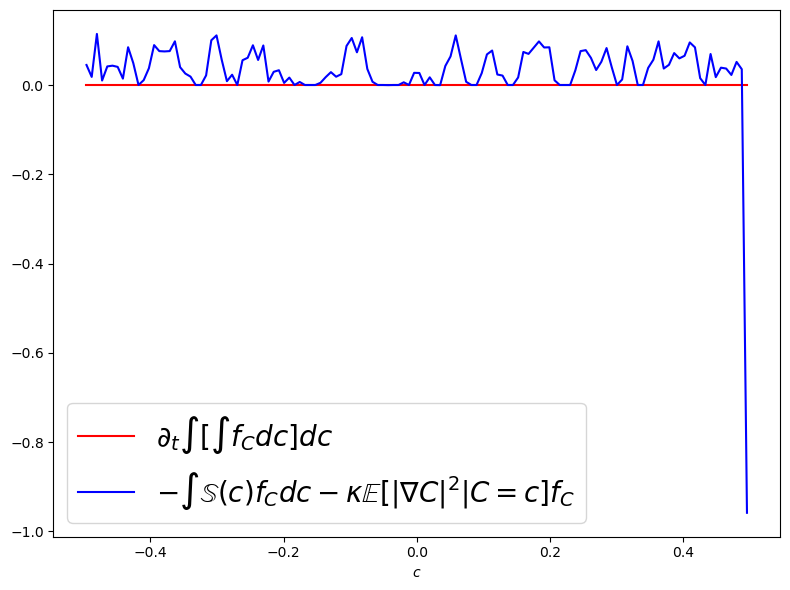

In [ ]:
# Plotting
fig = plt.figure(figsize=(8,6))
LHS = np.linalg.inv(L)@dfdt;
RHS = -kappa*E*f_C -int_Sf_C
plt.plot(c,LHS,'r-',label=r'$\partial_t \int [\int f_C dc] dc$')
plt.plot(c,RHS,'b-',label=r'$- \int \mathbb{S}(c) f_C dc -\kappa \mathbb{E}[ |\nabla C|^2 |C=c] f_C $')

plt.xlabel(r'$c$')
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('Equation_terms_HIST.png',dpi=200)
plt.show()

Plotting these terms above we see that the left and right hand sides balance thus numerically validating our equation for this example. Below we also plot the PDF conditional expectation and the scalar conecentration $C(z;t=1)$.

2024-01-17 17:40:33,061 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-17 17:40:33,169 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-17 17:40:33,431 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-01-17 17:40:33,663 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


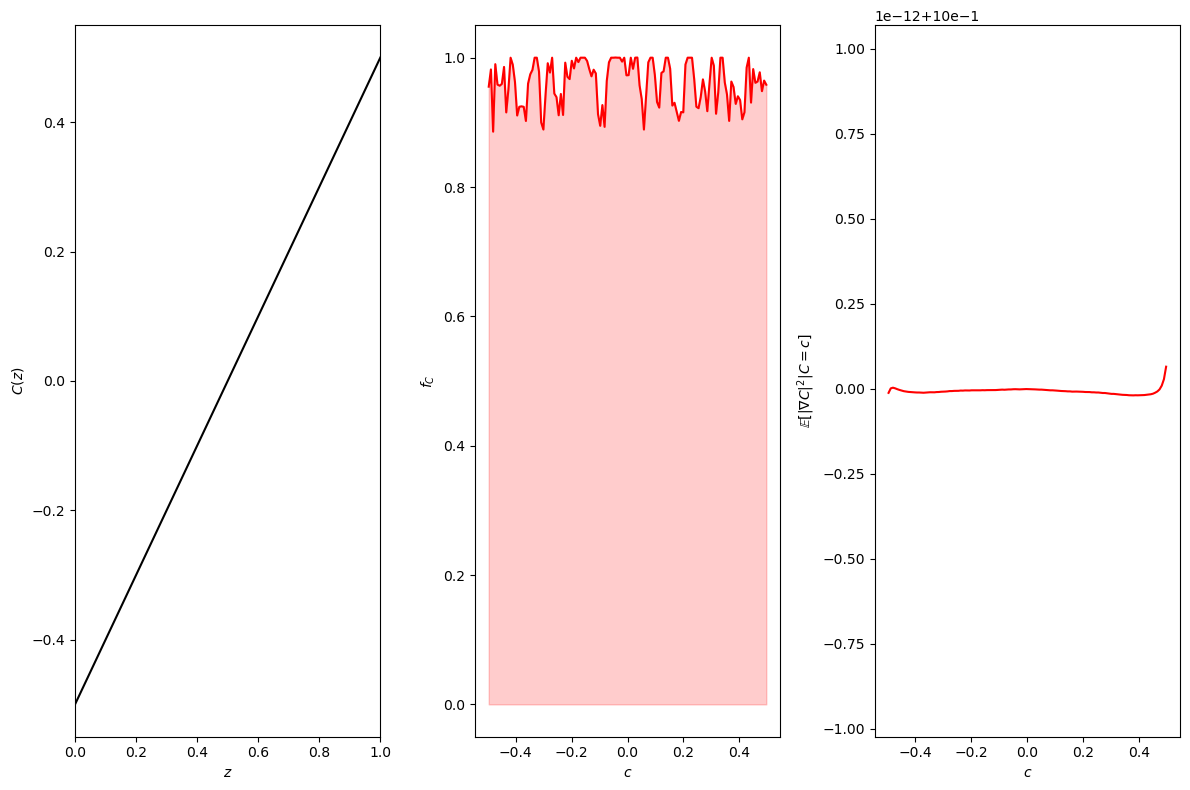

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].plot(z_data,C_data[-1,:],'k')
axs[0].set_xlim([0,1])
axs[0].set_ylabel(r'$C(z)$')
axs[0].set_xlabel(r'$z$')

axs[1].plot(c,f_C,'r')
axs[1].fill_between(x=c,y1=f_C,color= "r",alpha= 0.2)
axs[1].set_ylabel(r'$f_C$')
axs[1].set_xlabel(r'$c$')

axs[2].plot(c,E,'r')
axs[2].set_ylabel(r'$\mathbb{E}[|\nabla C|^2 |C=c]$')
axs[2].set_xlabel(r'$c$')

plt.tight_layout()
plt.savefig('Field_And_PDF.png',dpi=200)
plt.show()